In [4]:
import pickle as pkl

# Loading the model

In [5]:
with open('model.pkl', 'rb') as f:
    model = pkl.load(f)

model.summary()

W0000 00:00:1732804803.255988    2384 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_43 (Conv2D)              │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 24, 24, 32)     │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 8, 8, 64)       │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 395,651 (1.51 MB)

 Trainable params: 131,818 (514.91 KB)

 Non-trainable params: 194 (784.00 B)

 Optimizer params: 263,639 (1.01 MB)

In [22]:
import glob
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import numpy as np

# Helper functions and utils

In [ ]:
def create_dataset(df: pd.DataFrame, batch_size: int=32, test=False) -> tf.data.Dataset:
    """
    Create the dataset from the dataframe
    param df: pd.DataFrame: dataframe with the images path and labels
    param batch_size: int: batch size of the dataset
    param test: bool: if the dataset is for testing or not
    """
    imagegen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.)
    if not test:
        dataset = imagegen.flow_from_dataframe(
            df,
            x_col='images_path',
            y_col='labels',
            target_size=(28, 28),
            class_mode='raw',
            batch_size=batch_size,
        )
    else:
        dataset = imagegen.flow_from_dataframe(
            df,
            x_col='images_path',
            y_col='labels',
            target_size=(28, 28),
            class_mode='raw',
            batch_size=1,
            shuffle=False
        )
    return dataset



def model_predict(model, data) -> np.ndarray:
    """
    Predict the data using the model
    param model: the model to predict the data
    param data: the data to be used for prediction
    """
    predictions = model.predict(data)
    return np.argmax(predictions, axis=1)

def compare_predictions(predictions, labels) -> None:
    """
    Compare the predictions with the labels and print the accuracy
    param predictions: the predictions of the model
    param labels: the labels of the data
    """
    for i in predictions:
        print('Prediction:', class_to_name(i), end=' ')
        print('Label:', class_to_name(labels[i]))
    
    print('Accuracy:', np.mean(predictions == labels))

labels_map ={
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

def class_to_name(label) -> str:
    """
    Convert the label to the name of the class
    param label: int: label of the class
    """

    return labels_map[label]


In [ ]:

def read_images_from_path(path: str):
    """
    Read the images from the path and return a dataset
    param path: str: path to the images directory
    """
    images = []
    labels = []
    for filepath in glob.glob(path):
        images.append(filepath)
        labels.append(int(filepath.split('/')[-2]))

    test_df = pd.DataFrame({'images_path': images, 'labels': labels})
    return test_df

def evaluate_model(model, dataset, test_df):
    """
    Evaluate the model using the dataset and print the accuracy
    param model: the model to evaluate
    param dataset: the dataset to evaluate the model
    param test_df: the test dataframe
    """
    y_pred = model_predict(model, dataset)
    y_true = test_df.labels.values
    accuracy = np.mean(y_pred == y_true) 
    print('Accuracy:', accuracy)
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
    report = classification_report(y_true, y_pred)
    return report



We will create an example of test images for the test_df, we will only choose 1000 images after shuffling the test dataframe

# Testing the model

In [42]:
#for example, we assume the main path of the images is the path of test directory to test the model
test_df = read_images_from_path('./fashion_dataset/*/*.png')

In [ ]:

# shuffle the test_df
test_df = test_df.sample(frac=1).reset_index(drop=True)
example = test_df[:1000]
dataset = create_dataset(example, test=True)

Found 1000 validated image filenames.


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy: 0.953


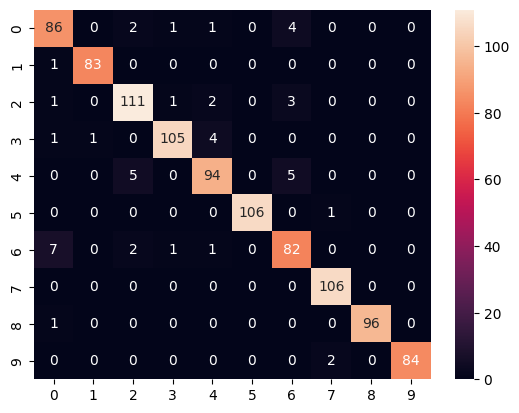

In [41]:
report = evaluate_model(model, dataset, example)

In [40]:
print(report)

              precision    recall  f1-score   support

           0       0.89      0.91      0.90        94
           1       0.99      0.99      0.99        84
           2       0.93      0.94      0.93       118
           3       0.97      0.95      0.96       111
           4       0.92      0.90      0.91       104
           5       1.00      0.99      1.00       107
           6       0.87      0.88      0.88        93
           7       0.97      1.00      0.99       106
           8       1.00      0.99      0.99        97
           9       1.00      0.98      0.99        86

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000

